In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from xgboost import  XGBClassifier #분류 모델 
from catboost import CatBoostClassifier
import statsmodels.api as sm
import platform
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline
import geopandas as gpd
import warnings
import shap
import pickle
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 로컬 모듈
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'src'))
from src.config import DATA_DIR, FONT_DIR, RESULT_DIR



/home/yeeun/anaconda3/envs/sparta-project2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 한글 폰트 설정
if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
elif platform.system() == "Darwin":  # macOS
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux
    plt.rcParams["font.family"] = "NanumGothic"

plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
prop = fm.FontProperties(fname=font_path)

In [3]:
# 데이터 불러오기
pandas_kwargs = {
    'parse_dates': ['purchase_time', 'approved_time', 'carrier_delivered_time', 'delivered_time', 'estimated_delivery_time'],
    'date_format': '%Y-%m-%d %H:%M:%S',
    'memory_map': True
}

df = pd.read_csv(DATA_DIR / 'processed' / 'processed_data.csv', **pandas_kwargs)

In [ ]:
# 시간 컬럼 변환
time_cols = ['purchase_time', 'approved_time', 'delivered_time', 'estimated_delivery_time']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 파생변수 생성
# 배송 딜레이
df['delivery_delay'] = (df['estimated_delivery_time'] - df['delivered_time']).dt.days
df['delivery_delay'] = df['delivery_delay'].apply(lambda x: -x if x < 0 else 0)
# 배송 기간
df['delivery_duration'] = (df['delivered_time'] - df['purchase_time']).dt.days

# 재구매 여부 생성
purchase_counts = df.groupby('customer_unique_id')['order_id'].count()
df['is_repurchase'] = (df['customer_unique_id'].map(purchase_counts) > 1).astype(int)

# 모델링 데이터 준비
features = ['delivery_delay', 'delivery_duration']
df_model = df[['is_repurchase'] + features].replace([np.inf, -np.inf], np.nan).dropna()

# 로지스틱 회귀분석 함수
def run_logit(X, y):
    X = sm.add_constant(X)
    return sm.Logit(y, X).fit(disp=0)

results = {
    'delivery_delay': run_logit(df_model[['delivery_delay']], df_model['is_repurchase']),
    'delivery_duration': run_logit(df_model[['delivery_duration']], df_model['is_repurchase'])
}

# 결과 저장
with open('test.txt', 'w', encoding='utf-8') as f:
    for i, (name, result) in enumerate(results.items(), 1):
        f.write(f"\n{i}. {name} x 재구매율")
        f.write(str(result.summary()))

In [ ]:
#재구매율 변수 중요도 파악
# 그리드 서치, smote 적용함

def feature_importance(df):
    #리뷰 점수 전처리
    df["review_score"] = pd.to_numeric(df["review_score"], errors="coerce")
    df.dropna(subset=["review_score"], inplace=True)
    df["review_score"] = df["review_score"].astype(int)

    #시간 관련 변수
    time_cols = ["purchase_time", "approved_time", "delivered_time", "estimated_delivery_time"]
    for col in time_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    df.dropna(subset=time_cols + ["customer_unique_id"], inplace=True)

    # 배송 기간 구매부터 배송 완료까지
    df["delivery_duration"] = (df['delivered_time'] - df['purchase_time']).dt.days
    # 예상 배송일 - 실제 배송일이면 양수 = xx일만큼 빠른 배송, 음수 = xx일만큼 늦은 배송
    df['delivery_delay'] = (df['estimated_delivery_time'] - df['delivered_time']).dt.days
    df['delivery_delay'] = df['delivery_delay'].apply(lambda x: -x if x < 0 else 0)

    #재구매 여부
    purchase_counts = df.groupby('customer_unique_id')['order_id'].count()
    df['is_repurchase'] = df['customer_unique_id'].map(purchase_counts).apply(lambda x: 1 if x > 1 else 0)

    display(f"전체 데이터 수 : {len(df)}")
    display(f"재구매 고객 : {df['is_repurchase'].sum()}")
    single_purchase_count = len(df) - df['is_repurchase'].sum()
    display(f"단일 구매 고객 : {single_purchase_count}")
    """
    리뷰 점수, 배송 기간, 배송 지연, 물품의 가격
    결제 할부 개월, 배송비, 물품 구매 수량
    결제 유형, 카테고리, 상품 사진 갯수
    물품 중량, 상품 설명 길이, 구매자의 도시
    """
    features = [
        'review_score', 'delivery_duration', 'delivery_delay', 'price',
        'payment_installments', 'freight_value', 'order_qty',
        'payment_type', 'category', 'photos_qty',
        'weight_g', 'content_length', 'state_cust']
    target = 'is_repurchase'

    model_df = df[features + [target] + ['purchase_time']].copy()

    # 범주형 변수 숫자형으로 변환
    category_features = ['payment_type', 'category', 'state_cust']
    for col in category_features:
        model_df[col] = model_df[col].astype('category').cat.codes
    
    # 데이터 분할
    split_point = int(len(model_df) * 0.8)
    X = model_df[features]
    y = model_df[target]

    X_train, X_test = X.iloc[:split_point].copy(), X.iloc[split_point:].copy()
    y_train, y_test = y.iloc[:split_point].copy(), y.iloc[split_point:].copy()

    # 숫자형 변수 스케일링
    num_features = X_train.select_dtypes(include=np.number).columns.tolist()
    # 범주형 코드는 스케일링에서 제외
    for cat_col in category_features:
        if cat_col in num_features:
            num_features.remove(cat_col)
            
    scaler = StandardScaler()
    X_train.loc[:, num_features] = scaler.fit_transform(X_train[num_features])
    X_test.loc[:, num_features] = scaler.transform(X_test[num_features])
    
    # SMOTE 적용
    category_indices = [X_train.columns.get_loc(c) for c in category_features if c in X_train]
    smote = SMOTENC(categorical_features=category_indices, random_state=42)
    
    #파이프라인 및 그리드
    xgb_pipe = Pipeline([
        ('smote', smote),
        ('model', XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='gpu_hist'))])
    
    xgb_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.1, 0.2]}
    
    #파이프라인 및 그리드
    cat_model = CatBoostClassifier(
        random_state=42,
        verbose=0,
        cat_features=category_indices,
        task_type='GPU')
    cat_pipe = Pipeline([
        ('smote', smote),
        ('model', cat_model)])
    
    cat_grid = {
        'model__iterations': [200, 300],
        'model__depth': [3, 5, 7],
        'model__learning_rate': [0.1, 0.2]}

    # 모델과 그리드를 딕셔너리로 관리
    models_and_grids = {
        "XGBoost": (xgb_pipe, xgb_grid),
        "CatBoost": (cat_pipe, cat_grid)}

    for name, (pipe, grid) in models_and_grids.items():
        display(f"\n {name} 그리드서치 훈련 시작")

        grid_search = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            cv=3,
            scoring='f1',
            verbose=1)
            #n_jobs=-1) # 모든 CPU
    
        # 그리드서치 훈련
        grid_search.fit(X_train, y_train)
        display(f"{name} 최적 f1: {grid_search.best_score_:.4f}")
        display(f"{name} 최적 하이퍼파라미터: {grid_search.best_params_}")

        # 최적 모델로 평가
        best_model = grid_search.best_estimator_

        # 평가는 원본으로
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        display(f"\n 모델 정확도 accuracy: {accuracy:.4f}")
        print(f"모델 f1: {f1:.4f}")

        target_names = ['단일 구매', '재구매']
        display("\n Classification Report")
        display(classification_report(y_test, y_pred, target_names=target_names))

        # 변수 중요도 시각화
        importances = best_model.named_steps['model'].feature_importances_
        feature_importances = pd.DataFrame({
            'feature': X.columns,
            'importance': importances
        })
        feature_importances = feature_importances.sort_values(
            by='importance', ascending=False
        ).reset_index(drop=True)

        display(f"\n {name} 최적모델 주요 변수")
        display(feature_importances)

        plt.figure(figsize=(10, 10))
        sns.barplot(x='importance', y='feature', data=feature_importances)
        plt.title(f"{name} 재구매에 영향을 끼치는 특성 중요도", fontweight="bold", fontsize=24)
        plt.xlabel('중요도', fontsize=12)
        plt.ylabel('특성', fontsize=12, rotation=0)
        plt.tight_layout()
        plt.show()
        # shap
        model = best_model.named_steps['model']

        if name == "XGBoost":
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # 파일 저장
            np.save(f"{name}_shap_values.npy", shap_values)
            X_test.to_csv(f"{name}_X_test.csv", index=False)

            feature_importances.to_csv(f"{name}_feature_importances.csv", index=False)
            print(f" {name} shap_values, X_test, feature_importances 저장 완료")

        elif name == "CatBoost":
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # 파일 저장
            np.save(f"{name}_shap_values.npy", shap_values)
            X_test.to_csv(f"{name}_X_test.csv", index=False)

            feature_importances.to_csv(f"{name}_feature_importances.csv", index=False)
            print(f" {name} shap_values, X_test, feature_importances 저장 완료")
        


        #중요도
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title(f"{name} SHAP 특성 영향도", fontsize=24)
        plt.show()

        #방향성
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title(f"{name} 특성 영향 방향성 (SHAP)", fontweight="bold", fontsize=24)
        plt.show()

        #변수의 SHAP 관계
        top_feature = feature_importances.iloc[0]['feature']
        display(f" Top Feature: {top_feature}")
        shap.dependence_plot(top_feature, shap_values, X_test, show=False)
        plt.title(f"{name} - {top_feature} SHAP 효과", fontweight="bold", fontsize=24)
        plt.show()

    # SHAP summary 대신 커스텀 막대그래프
    shap_importance = pd.DataFrame({
        'feature': X_test.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    colors = ['#0A4EE4' if i == 0 else '#1E90FF' for i in range(len(shap_importance))]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='mean_abs_shap',
        y='feature',
        data=shap_importance,
        palette=colors
    )
    plt.title(f"{name} SHAP 특성 영향도", fontsize=24, fontweight="bold")
    plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


feature_importance(df)

# 시각화

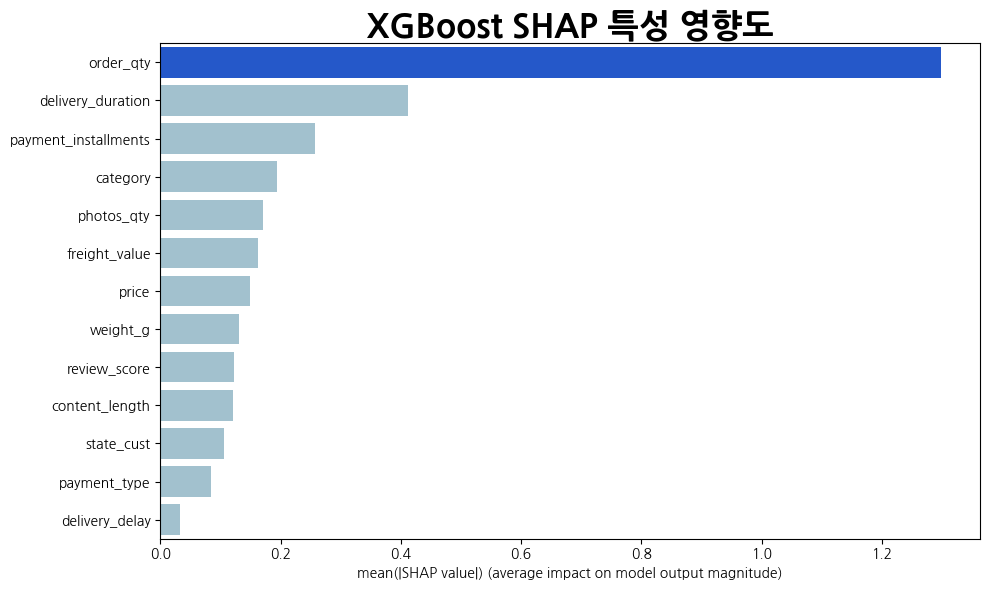

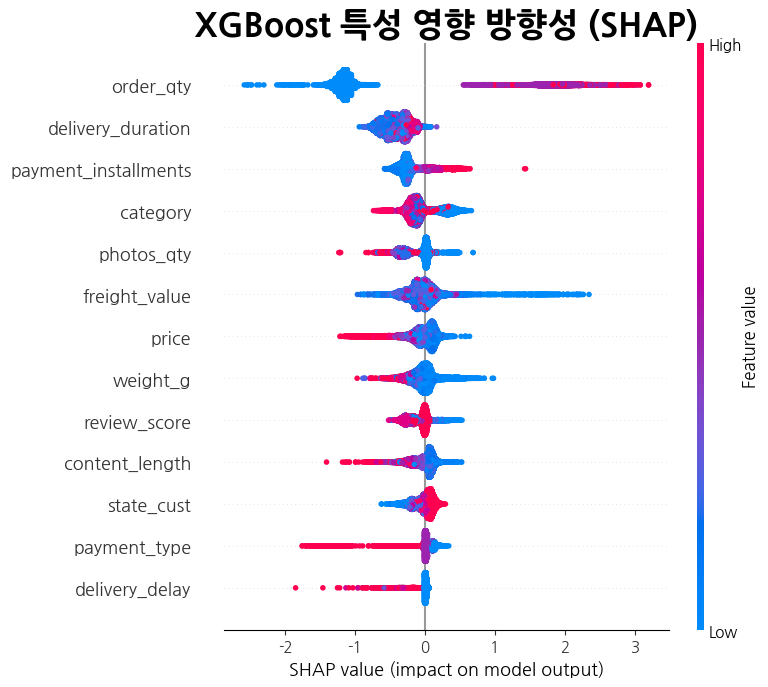

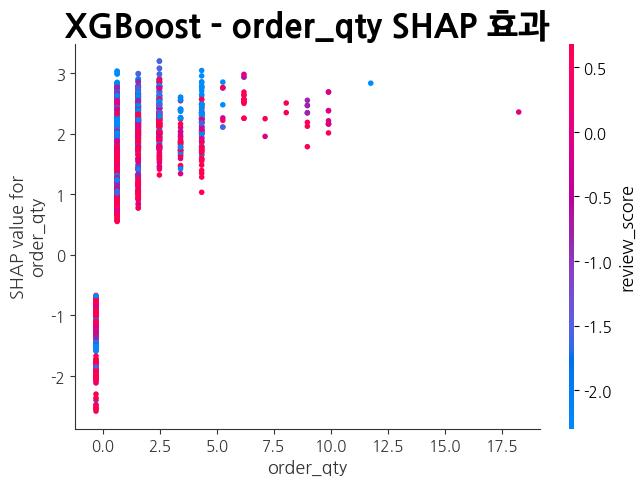

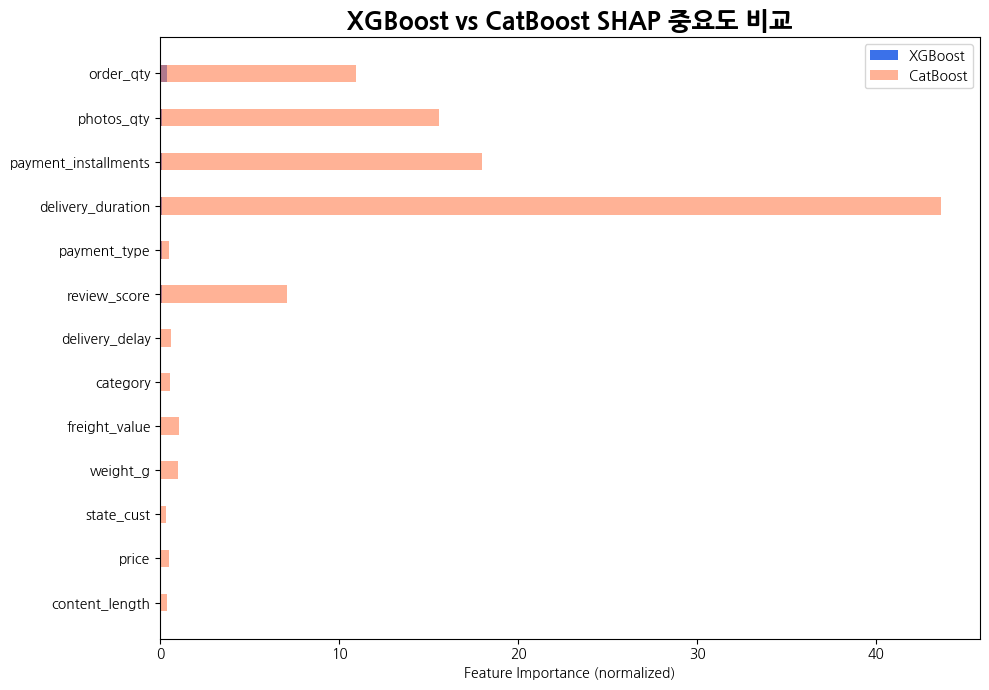

In [4]:
shap_values = np.load(RESULT_DIR /"XGBoost_shap_values.npy")
X_test = pd.read_csv(RESULT_DIR / "XGBoost_X_test.csv")
feature_importances = pd.read_csv(RESULT_DIR / "XGBoost_feature_importances.csv")

shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

colors = ["#0A4EE4" if i == 0 else "#9BC4D5" for i in range(len(shap_importance))]


plt.figure(figsize=(10, 6))
sns.barplot(
    x="mean_abs_shap",
    y="feature",
    data=shap_importance,
    palette=colors
)
plt.title("XGBoost SHAP 특성 영향도", fontsize=24, fontweight="bold")
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# SHAP 분포 그래프
shap.summary_plot(shap_values, X_test, show=False)
plt.title("XGBoost 특성 영향 방향성 (SHAP)", fontsize=24, fontweight="bold")
plt.show()

# 가장 영향 큰 변수의 SHAP 관계
top_feature = shap_importance.iloc[0]["feature"]
shap.dependence_plot(top_feature, shap_values, X_test, show=False)
plt.title(f"XGBoost - {top_feature} SHAP 효과", fontsize=24, fontweight="bold")
plt.show()

# ====
xgb_imp = pd.read_csv(RESULT_DIR / "XGBoost_feature_importances.csv")
cat_imp = pd.read_csv(RESULT_DIR /"CatBoost_feature_importances.csv")

# 두 데이터프레임 정규화 
merged = pd.merge(
    xgb_imp.rename(columns={"importance": "XGBoost"}),
    cat_imp.rename(columns={"importance": "CatBoost"}),
    on="feature",
    how="inner"
)

# 중요도 합 기준으로 정렬
merged = merged.sort_values(by=["XGBoost", "CatBoost"], ascending=False)
features = merged["feature"]

# 그래프 크기 및 스타일
plt.figure(figsize=(10, 7))
bar_width = 0.4

# x 위치 정의
x = np.arange(len(features))

# 겹쳐진 bar — alpha로 투명도 조절
plt.barh(x, merged["XGBoost"], height=bar_width, label="XGBoost", color="#0A4EE4", alpha=0.8)
plt.barh(x, merged["CatBoost"], height=bar_width, label="CatBoost", color="#FF7F50", alpha=0.6)

# 세부 설정
plt.yticks(x, features)
plt.gca().invert_yaxis()  # 위에서부터 순서대로 표시
plt.xlabel("Feature Importance (normalized)")
plt.title("XGBoost vs CatBoost SHAP 중요도 비교", fontsize=18, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
shap_values = np.load("CatBoost_shap_values.npy")
X_test = pd.read_csv(RESULT_DIR / "CatBoost_X_test.csv")
feature_importances = pd.read_csv(RESULT_DIR /"CatBoost_feature_importances.csv")

shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

colors = ["#0A4EE4" if i == 0 else "#9BC4D5" for i in range(len(shap_importance))]


plt.figure(figsize=(10, 6))
sns.barplot(
    x="mean_abs_shap",
    y="feature",
    data=shap_importance,
    palette=colors
)
plt.title("CatBoost SHAP 특성 영향도", fontsize=24, fontweight="bold")
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
# XGBoost 데이터
xgb_shap_values = np.load("XGBoost_shap_values.npy")
xgb_X_test = pd.read_csv("XGBoost_X_test.csv")
xgb_shap_importance = pd.DataFrame({
    "feature": xgb_X_test.columns,
    "mean_abs_shap": np.abs(xgb_shap_values).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

xgb_colors = ["#0A4EE4" if i == 0 else "#9BC4D5" for i in range(len(xgb_shap_importance))]

# CatBoost 데이터
cat_shap_values = np.load("CatBoost_shap_values.npy")
cat_X_test = pd.read_csv("CatBoost_X_test.csv")
cat_shap_importance = pd.DataFrame({
    "feature": cat_X_test.columns,
    "mean_abs_shap": np.abs(cat_shap_values).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

cat_colors = ["#0A4EE4" if i == 0 else "#9BC4D5" for i in range(len(cat_shap_importance))]

fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 

# XGBoost 그래프
sns.barplot(
    x="mean_abs_shap",
    y="feature",
    data=xgb_shap_importance,
    palette=xgb_colors,
    ax=axes[0]
)
axes[0].set_title("XGBoost 특성 영향도 (SHAP)", fontsize=18, fontweight="bold")
axes[0].set_xlabel("mean(|SHAP value|)")
axes[0].set_ylabel("")

# CatBoost 그래프
sns.barplot(
    x="mean_abs_shap",
    y="feature",
    data=cat_shap_importance,
    palette=cat_colors,
    ax=axes[1]
)
axes[1].set_title("CatBoost 특성 영향도 (SHAP)", fontsize=18, fontweight="bold")
axes[1].set_xlabel("mean(|SHAP value|)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
#물류 분석 + 시각화
def run_geo():
    df = pd.read_csv(DATA_DIR / 'processed' / 'processed_data.csv', **pandas_kwargs)
    brazil_gdf = gpd.read_file('brazil_all_states.json')
    
    # 시간 관련 변수 생성
    time_cols = ['purchase_time', 'delivered_time', 'estimated_delivery_time']
    for col in time_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
    # 배송 기간 구매부터 배송 완료까지
    df['delivery_duration'] = (df['delivered_time'] - df['purchase_time']).dt.days
    # 예상 배송일 - 실제 배송일이면 양수 = xx일만큼 빠른 배송, 음수 = xx일만큼 늦은 배송
    #0보다 작은 경우(지연)에만 -1을 곱해 양수로 만듦 (지연 일수)
    df['delivery_delay'] = (df['estimated_delivery_time'] - df['delivered_time']).dt.days
    df['delivery_delay'] = df['delivery_delay'].apply(lambda x: -x if x < 0 else 0)

    # 구매자 카테고리별 물류 부담 분석
    category_curs = df.groupby(['state_cust', 'category']).agg(
        avg_freight_value=('freight_value', 'mean'), #배송비
        median_freight_value=('freight_value', 'median'), # 배송비
        avg_delivery_duration=('delivery_duration', 'mean'), # 배송기간
        median_delivery_duration=('delivery_duration', 'median'), # 배송기간
        avg_weight_g=('weight_g', 'mean'), #중량
        median_weight_g=('weight_g', 'median'), #중량
        order_count=('order_id', 'count')# 주문수
    ).sort_values(by='avg_freight_value', ascending=False).reset_index()
    
    state_curs_total = category_curs.groupby('state_cust')['order_count'].transform('sum')
    category_curs['category_ratio'] = category_curs['order_count'] / state_curs_total
    
    # 판매자 카테고리별 물류 부담 분석
    category_sell = df.groupby(['state_sell', 'category']).agg(
        avg_freight_value=('freight_value', 'mean'), #배송비
        median_freight_value=('freight_value', 'median'), # 배송비
        avg_delivery_duration=('delivery_duration', 'mean'), # 배송기간
        median_delivery_duration=('delivery_duration', 'median'), # 배송기간
        avg_weight_g=('weight_g', 'mean'), #중량
        median_weight_g=('weight_g', 'median'), #중량
        order_count=('order_id', 'count')# 주문수
    ).sort_values(by='avg_freight_value', ascending=False).reset_index()

    state_sell_total = category_sell.groupby('state_sell')['order_count'].transform('sum')
    category_sell['category_ratio'] = category_sell['order_count'] / state_sell_total

    # 결과 저장
    category_curs.to_csv('구매자_물류_통계.csv', index=False, encoding='utf-8-sig')
    category_sell.to_csv('판매자_물류_통계.csv', index=False, encoding='utf-8-sig')

    # 지역별 배송 비효율
    state_delivery = df.groupby('state_cust').agg(
        avg_delivery_duration=('delivery_duration', 'mean'),#배송 기간 평균
        avg_delivery_delay=('delivery_delay', 'mean') #배송 딜레이 평균
    ).reset_index()
    
    # 취약지역 뽑기용
    state_delivery_f = state_delivery.sort_values(by='avg_delivery_duration', ascending=False)

    state_delivery_filename = '지역_배송_비효율.csv'
    state_delivery_f.to_csv(state_delivery_filename, index=False, encoding='utf-8-sig')
    print(f" - '{state_delivery_filename}' 파일 저장 완료")

    # 시각화
    brazil_state = brazil_gdf[['UF', 'geometry']].dissolve(by='UF').reset_index()
    map_data = brazil_state.merge(state_delivery, left_on='UF', right_on='state_cust', how='left')

    # 시각화 1 평균 배송 소요 시간
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    map_data.plot(column='avg_delivery_duration', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                  legend_kwds={'label': "평균 배송 소요 시간 (일)", 'orientation': "horizontal"})
    ax.set_title('브라질 주(State)별 평균 배송 소요 시간', fontweight="bold", fontsize=24)
    ax.axis('off')
    
    # 파일 저장
    map_output_filename_1 = 'brazil_delivery_duration_map.png'
    plt.savefig(map_output_filename_1, dpi=300)
    print(f" - 시각화 1 결과가 '{map_output_filename_1}' 파일로 저장")
    
    plt.show()
    

    # 시각화 2 평균 배송 지연
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    map_data.plot(column='avg_delivery_delay', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                  legend_kwds={'label': "평균 배송 지연 일수 (일)", 'orientation': "horizontal"})
    ax.set_title('브라질 주(State)별 평균 배송 지연 일수', fontweight="bold", fontsize=24)
    ax.axis('off')
    map_output_filename_2 = 'brazil_delivery_delay_map.png'
    plt.savefig(map_output_filename_2, dpi=300)
    print(f" - 시각화 2 결과가 '{map_output_filename_2}' 파일로 저장")
    
    
    plt.show()

    # 시각화 3 판매자-구매자 위치 포인트
    gdf_sellers = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude_sell, df.latitude_sell), crs="EPSG:4326")
    gdf_customers = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude_cust, df.latitude_cust), crs="EPSG:4326")

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    """
    # 배경지도
    map_data.plot(ax=ax, color='lightgray', edgecolor='0.8', label='브라질 주')
    
    # 구매자 위치 산점도
    gdf_customers.plot(ax=ax, marker='x', color='red', markersize=5, alpha=0.3, label='구매자 위치')
    # 판매자 위치 산점도
    gdf_sellers.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.3, label='판매자 위치')
    
    ax.set_title('판매자 및 구매자 위치 분포도', fontdict={'fontsize': '16', 'fontweight': '3'})
    ax.axis('off')
    ax.legend(loc='upper right', markerscale=2)
    """
    # 배경지도 avg_delivery_duration버전
    map_data.plot(column='avg_delivery_duration', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8',
                  legend=True, legend_kwds={'label': "평균 배송 소요 시간 (일)", 'orientation': "horizontal"})
    
    # 구매자 위치 산점도
    gdf_customers.plot(ax=ax, marker='x', color='red', markersize=5, alpha=0.3, label='구매자 위치')
    # 판매자 위치 산점도
    gdf_sellers.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.3, label='판매자 위치')
    
    ax.set_title('판매자 및 구매자 위치 분포도 (배경: 평균 배송 소요 시간)', fontweight="bold", fontsize=24)
    ax.axis('off')
    ax.legend(loc='upper right')

    # 저장
    map_output_filename_3 = 'brazil_seller_customer_distribution.png'
    plt.savefig(map_output_filename_3, dpi=300, bbox_inches='tight')
    print(f"분포도가 '{map_output_filename_3}' 파일로 저장.")
    plt.show()

if __name__ == '__main__':
    run_geo()